In [216]:
import numpy as np
"""
Computes camera matrix given image and real-world coordinates.

    Args:
        real_XY: Each row corresponds to an actual point on the 2D plane.
        front_image: Each row is the pixel location in the front image (Z=0).
        back_image: Each row is the pixel location in the back image (Z=150).
    Returns:
        camera_matrix: The calibrated camera matrix (3x4 matrix).
"""
"I guess such corresponding points are hand-crafted"
real_XY = np.load('real_XY.npy')
front_image = np.load('front_image.npy')
back_image = np.load('back_image.npy')

#### 1. Perspective Camera Calibration

Deal with 11 DFs camera matrix with 12 parameters in total, solved through constraint minimization problem with SVD.

#### 2. Affine Camera Calibration

Deal with 8 DFs camera matrix with 8 parameters in total, solved with LSE on linear system.

In [167]:
# world coordinates: (M,3), image_coordinates: (M,2)
def calibrate_perspective_camera(world_coordinates, image_coordinates):
    wc,ic = world_coordinates, image_coordinates
    wc = np.pad(wc,[(0,0),(0,1)],mode='constant',constant_values=1.) # (M,4)
    pstack = np.repeat(wc, repeats=2, axis=0) # (2M,4)
    # scale even & odd rows with different values
    v1 = np.array([1,0])
    tmp1 = np.tile(v1,wc.shape[0])[:,np.newaxis] * pstack # (2M,4)
    v2 = np.array([0,1])
    tmp2 = np.tile(v2,wc.shape[0])[:,np.newaxis] * pstack # (2M,4)
    pix = ic.reshape(-1,1) # (2M,1)    
    tmp3 = - pix * pstack # (2M,4)
    P = np.concatenate((tmp1,tmp2,tmp3),axis=1) # (2M,12)
    # optimization problem solved with Singular Value Decomposition
    u,s,vh = np.linalg.svd(P)
    # take last column of V, or the last row of V.T: (12,)
    sol = vh[-1]
    # construct camera matrix M: (3,4)
    M = sol.reshape(3,4)
    return M

# affine camera model: Standard Least Squares
def calibrate_affine_camera(world_coordinates, image_coordinates):
    wc,ic = world_coordinates, image_coordinates
    wc = np.pad(wc,[(0,0),(0,1)],mode='constant',constant_values=1.) # (M,4)
    pstack = np.repeat(wc, repeats=2, axis=0) # (2M,4)
    # scale even & odd rows with different values
    v1 = np.array([1,0])
    tmp1 = np.tile(v1,wc.shape[0])[:,np.newaxis] * pstack # (2M,4)
    v2 = np.array([0,1])
    tmp2 = np.tile(v2,wc.shape[0])[:,np.newaxis] * pstack # (2M,4)
    P = np.concatenate((tmp1,tmp2),axis=1) # (2M,8)
    b = image_coordinates.reshape(-1,1) # (2M,1)
    m_ls = np.linalg.inv(P.T@P)@(P.T)@b # (8,1)
    # construct affine camera matrix
    M12 = m_ls.reshape(2,4) # (2,4)
    M3 = np.array([[0.,0.,0.,1.]]) # (1,4)
    M = np.concatenate((M12,M3),axis=0)
    return M

To generalize the usage, specify world_coordinates (-1,3) and image_coordinates (-1,2) for application of above function.

In [213]:
# world coordinate for first imageL (N,3)
wc1 = np.pad(real_XY,[(0,0),(0,1)],mode='constant',constant_values=0.)
# world coordinate for second image: (N,3)
wc2 = np.pad(real_XY,[(0,0),(0,1)],mode='constant',constant_values=150.)
# world coordinates (3D) and image coordinate (2D) construction
world_coordinates = np.concatenate((wc1,wc2),axis=0) # (2N,3)
image_coordinates = np.concatenate((front_image,back_image)) # (2N,2)

# fit the perspective camera model
M0 = calibrate_perspective_camera(world_coordinates, image_coordinates)
M1 = calibrate_affine_camera(world_coordinates, image_coordinates)
print('Calibrated Perspective Camera model is:\n',M0)
print('\n Calibrated Affine Camera model is:\n',M1)

Calibrated Perspective Camera model is:
 [[ 3.86081985e-03 -1.14839115e-04  8.75272791e-04  9.46068598e-01]
 [ 3.42814033e-04  3.92515324e-03 -7.51681648e-04  3.23835234e-01]
 [-6.97426063e-08  8.23266292e-08 -1.33752672e-08  7.29214554e-03]]

 Calibrated Affine Camera model is:
 [[ 5.31276507e-01 -1.80886074e-02  1.20509667e-01  1.29720641e+02]
 [ 4.84975447e-02  5.36366401e-01 -1.02675222e-01  4.43879607e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


#### 3. RMS Error

In [214]:
def rms_error(world_coordinates, image_coordinates, camera_matrx):
    wc,ic,M = world_coordinates, image_coordinates, camera_matrx
    # obtain predicted image coordinate
    wc_proj = np.pad(wc,[(0,0),(0,1)],mode='constant',constant_values=1) # (M,4)
    pred_ic_proj = (M @ wc_proj[:,:,np.newaxis])[:,:,0] # (M,3)
    pred_ic = pred_ic_proj[:,:2]/pred_ic_proj[:,2:] # (M,2)
    # compute RMS
    sq_diff = np.sum((pred_ic - ic)**2,axis=1)
    rms = np.sqrt(np.mean(sq_diff))
    return rms

print('RMS for calibrated perspective camera model is:',rms_error(world_coordinates, image_coordinates, M0))
print('RMS for calibrated affine camera model is:',rms_error(world_coordinates, image_coordinates, M1))

RMS for calibrated perspective camera model is: 0.9916933372299293
RMS for calibrated affine camera model is: 0.9938304832798437


#### 4. Compute Vanishing points

In [455]:
# input four points: pts[0]-pts[1] form one parallel line, pts[2]-pts[3] another
def compute_vanishing_point(pts):
    a1 = (pts[1] - pts[0])[::-1] * np.array([1,-1])
    a2 = (pts[3] - pts[2])[::-1] * np.array([1,-1])
    c1 = np.sum(pts[0]*a1)
    c2 = np.sum(pts[2]*a2)
    v = np.linalg.solve(np.stack((a1,a2)), np.stack((c1,c2)))
    return v

def compute_K_from_vanishing_points(vanishing_points):
    v1,v2,v3 = vanishing_points
    A1 = np.array([v1[0]*v2[0]+v1[1]*v2[1],v1[0]+v2[0],v1[1]+v2[1],1])
    A2 = np.array([v1[0]*v3[0]+v1[1]*v3[1],v1[0]+v3[0],v1[1]+v3[1],1])
    A3 = np.array([v2[0]*v3[0]+v2[1]*v3[1],v2[0]+v3[0],v2[1]+v3[1],1])
    A = np.vstack((A1,A2,A3))
    # solve for w', the wrongly scaled solution
    u,s,vt = np.linalg.svd(A)
    w = vt[-1]
    # construct omega from w values
    omega = np.array([[w[0],0,w[1]],
                      [0,w[0],w[2]],
                      [w[1],w[2],w[3]]])
    # Cholesky decomposition to get wrongly scaled intrinsic matrix K
    KT_inv = np.linalg.cholesky(omega)
    K = np.linalg.inv(KT_inv.T)
    # normalized K to the correctly scaled, thanks to the fact that K[2,2]=1
    K /= K[2,2]
    return K

In [448]:
A

⎡v_{1x}⋅v_{2x} + v_{1y}⋅v_{2y}  v_{1x} + v_{2x}  v_{1y} + v_{2y}  1⎤
⎢                                                                  ⎥
⎢v_{1x}⋅v_{3x} + v_{1y}⋅v_{3y}  v_{1x} + v_{3x}  v_{1y} + v_{3y}  1⎥
⎢                                                                  ⎥
⎣v_{2x}⋅v_{3x} + v_{2y}⋅v_{3y}  v_{2x} + v_{3x}  v_{2y} + v_{3y}  1⎦

#### Interesting Automatic Algebra
Below cell uses Sympy to verify the expression of $\omega$ indeed admits the forms given in the lecture note.

1. Verification of expression of $\omega$ can be viewed in $(w1,w2,w3,w4)$ sense

In [422]:
# verification of the omega expression
import sympy as sym

sym.init_printing()
sf,stx,sty = sym.symbols('f t_x t_y')
K = sym.Matrix([[sf,0,stx],
                [0,sf,sty],
                [0, 0, 1]])
omega = (K @ K.T).inv()
sym.simplify(omega)

⎡ 1                -tₓ       ⎤
⎢ ──     0         ────      ⎥
⎢  2                 2       ⎥
⎢ f                 f        ⎥
⎢                            ⎥
⎢       1          -t_y      ⎥
⎢ 0     ──         ─────     ⎥
⎢        2            2      ⎥
⎢       f            f       ⎥
⎢                            ⎥
⎢              2     2      2⎥
⎢-tₓ   -t_y   f  + tₓ  + t_y ⎥
⎢────  ─────  ───────────────⎥
⎢  2      2           2      ⎥
⎣ f      f           f       ⎦

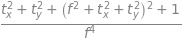

In [430]:
# the TRUE ||w||**2 is
wscale = omega[0,0]**2 + omega[0,2]**2 + omega[1,2]**2 + omega[2,2]**2
sym.simplify(wscale)

In [428]:
# the determinant of the TRUE omega matrix is given as
omega.det()

In [447]:
"We can use SymPy to compute the matrix A directly"
"We can choose to use such expression to construct the function accordingly"
v1x,v1y,v2x,v2y,v3x,v3y = sym.symbols('v_{1x} v_{1y} v_{2x} v_{2y} v_{3x} v_{3y}')
v1 = sym.Matrix([[v1x,v1y,1]]).T
v2 = sym.Matrix([[v2x,v2y,1]]).T
v3 = sym.Matrix([[v3x,v3y,1]]).T

w1,w2,w3,w4 = sym.symbols('w_1 w_2 w_3 w_4')
omega = sym.Matrix([[w1,0,w2],
                    [0,w1,w3],
                    [w2,w3,w4]])

eq1 = v1.T @ omega @ v2 
eq2 = v1.T @ omega @ v3
eq3 = v2.T @ omega @ v3

A1,b1 = sym.linear_eq_to_matrix(eq1,[w1,w2,w3,w4])
A2,b2 = sym.linear_eq_to_matrix(eq2,[w1,w2,w3,w4])
A3,b3 = sym.linear_eq_to_matrix(eq3,[w1,w2,w3,w4])

A = sym.Matrix.vstack(A1,A2,A3)
b = sym.Matrix.vstack(b1,b2,b3)
sym.linsolve((A,b),[w1,w2,w3,w4])
A

⎡v_{1x}⋅v_{2x} + v_{1y}⋅v_{2y}  v_{1x} + v_{2x}  v_{1y} + v_{2y}  1⎤
⎢                                                                  ⎥
⎢v_{1x}⋅v_{3x} + v_{1y}⋅v_{3y}  v_{1x} + v_{3x}  v_{1y} + v_{3y}  1⎥
⎢                                                                  ⎥
⎣v_{2x}⋅v_{3x} + v_{2y}⋅v_{3y}  v_{2x} + v_{3x}  v_{2y} + v_{3y}  1⎦

Automatically doing algebra to obtain A

In [433]:
"""
This cell is used to conduct linear algebra automatically with SymPy
Solve for v_{i}.T @ omega @ v_{j} = 0, (i,j) = {(1,2),(1,3),(2,3)}
Where omega is characterized with w1,w2,w3,w4 (this is verified using inv(KK.T) expression)
We can equivalently write Aw=0, and this cell solve for A algebraically 
and return the resulting A as a numpy array
"""

v1x,v1y,v2x,v2y,v3x,v3y = sym.symbols('v_{1x} v_{1y} v_{2x} v_{2y} v_{3x} v_{3y}')
v1 = sym.Matrix([[v1x,v1y,1]]).T
v2 = sym.Matrix([[v2x,v2y,1]]).T
v3 = sym.Matrix([[v3x,v3y,1]]).T

v1_ = v1.subs([(v1x,v1a[0]),(v1y,v1a[1])])
v2_ = v2.subs([(v2x,v2a[0]),(v2y,v2a[1])])
v3_ = v3.subs([(v3x,v3a[0]),(v3y,v3a[1])])

w1,w2,w3,w4 = sym.symbols('w_1 w_2 w_3 w_4')
omega = sym.Matrix([[w1,0,w2],
                    [0,w1,w3],
                    [w2,w3,w4]])

eq1 = v1_.T @ omega @ v2_ 
eq2 = v1_.T @ omega @ v3_
eq3 = v2_.T @ omega @ v3_

A1,b1 = sym.linear_eq_to_matrix(eq1,[w1,w2,w3,w4])
A2,b2 = sym.linear_eq_to_matrix(eq2,[w1,w2,w3,w4])
A3,b3 = sym.linear_eq_to_matrix(eq3,[w1,w2,w3,w4])

A = sym.Matrix.vstack(A1,A2,A3)
b = sym.Matrix.vstack(b1,b2,b3)
d = sym.linsolve((A,b),[w1,w2,w3,w4])

A = np.array(A, dtype=float)

In [434]:
A

array([[-4.60869927e+06,  5.79590565e+03, -8.20305482e+02,
         1.00000000e+00],
       [ 3.32944234e+06,  7.70783104e+03,  5.77453686e+03,
         1.00000000e+00],
       [-1.72818047e+06,  4.69292338e+02,  6.32569736e+03,
         1.00000000e+00]])

In [446]:
# solve for w', the wrongly scaled solution
u,s,vt = np.linalg.svd(A)
w = vt[-1]
# construct omega from w values
omega = np.array([[w[0],0,w[1]],
                  [0,w[0],w[2]],
                  [w[1],w[2],w[3]]])
# Cholesky decomposition to get wrongly scaled intrinsic matrix K
KT_inv = np.linalg.cholesky(omega)
K = np.linalg.inv(KT_inv.T)
# normalized K to the correctly scaled, thanks to the fact that K[2,2]=1
K /= K[2,2]
K

array([[2.59416985e+03, 0.00000000e+00, 7.73289548e+02],
       [0.00000000e+00, 2.59416985e+03, 9.79503278e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [432]:
# Part A: Compute vanishing points.
v1a = compute_vanishing_point(np.array(
        [[674, 1826], [2456, 1060], [1094, 1340], [1774, 1086]]))
v2a = compute_vanishing_point(np.array(
        [[674, 1826], [126, 1056], [2456, 1060], [1940, 866]]))
v3a = compute_vanishing_point(np.array(
        [[1094, 1340], [1080, 598], [1774, 1086], [1840, 478]]))

v1b = compute_vanishing_point(np.array(
        [[314, 1912], [2060, 1040], [750, 1378], [1438, 1094]]))
v2b = compute_vanishing_point(np.array(
        [[314, 1912], [36, 1578], [2060, 1040], [1598, 882]]))
v3b = compute_vanishing_point(np.array(
        [[750, 1378], [714, 614], [1438, 1094], [1474, 494]]))

# Part B: Compute the camera matrix.
vanishing_points = [v1a, v2a, v3a]

In [374]:
v1a

array([6517.22217664, -685.73298951])

In [375]:
v2a

array([-721.31652738, -134.57249285])

In [376]:
v3a

array([1190.60886508, 6460.269849  ])